<a href="https://colab.research.google.com/github/Berke-Yay/House-Sales-LinearRegressionModel/blob/main/LinearRegressionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Gerekli kütüphanelerin ve datasetin yüklenmesi

In [ ]:
#Program için gerekli kütüphaneler ve fonksiyonlar yüklendi
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

In [ ]:
#Kullanılacak dataset dosyası pandas aracılığıyla üzerinde çalışması daha kolay Dataframe haline getirildi.
dataset = pd.read_csv("kc_house_data.csv")
#Yukarıdaki satırın hata vermemesi için dosyanın colab notebook'una 'Files' kısmından yüklenmesi gerekiyor.

###Datasetin incelenmesi

In [ ]:
#Datasetin barındırdığı verinin boyutu incelendi: 21.613 ev, her evin 21 farklı özelliği var
print(dataset.shape)
#Datasetteki ilk 5 satır yazdırılarak evlerin sahip olduğu özelliklere ve erişildi.
dataset.head()

(21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [ ]:
#Evlerin sahip olduğu özelliklerin her biri column_names adlı listeye eklendi.
column_names = ['id','date', 'price', 'bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view',
            'condition','grade','sqft_above','sqft_basement','yr_built','yr_renovated', 'zipcode', 'lat','long',
            'sqft_living15','sqft_lot15']
#Evlerin sahip olduğu özelliklerden sayısal veri içerenler numerical_columns listesine, sayısal veri içermeyenler categorical_columns listesine eklendi
numerical_columns=[]
categorical_columns=[]

#Özelliklerin sayısal olup olmadığına karar verilirken datasette özelliğin bulunduğu sütunun altındaki verilerin tiplerine bakıldı
for i in column_names:
  if dataset[i].dtype not in ['int16','int32', 'int64', 'float16', 'float32', 'float64']:
    categorical_columns.append(i)
  else:
    numerical_columns.append(i)

In [ ]:
#Görünüşe göre 'date' hariç tüm özellikler zaten sayısalmış
print("Categorical columns:",categorical_columns)
print("Numerical columns:", numerical_columns)

Categorical columns: ['date']
Numerical columns: ['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


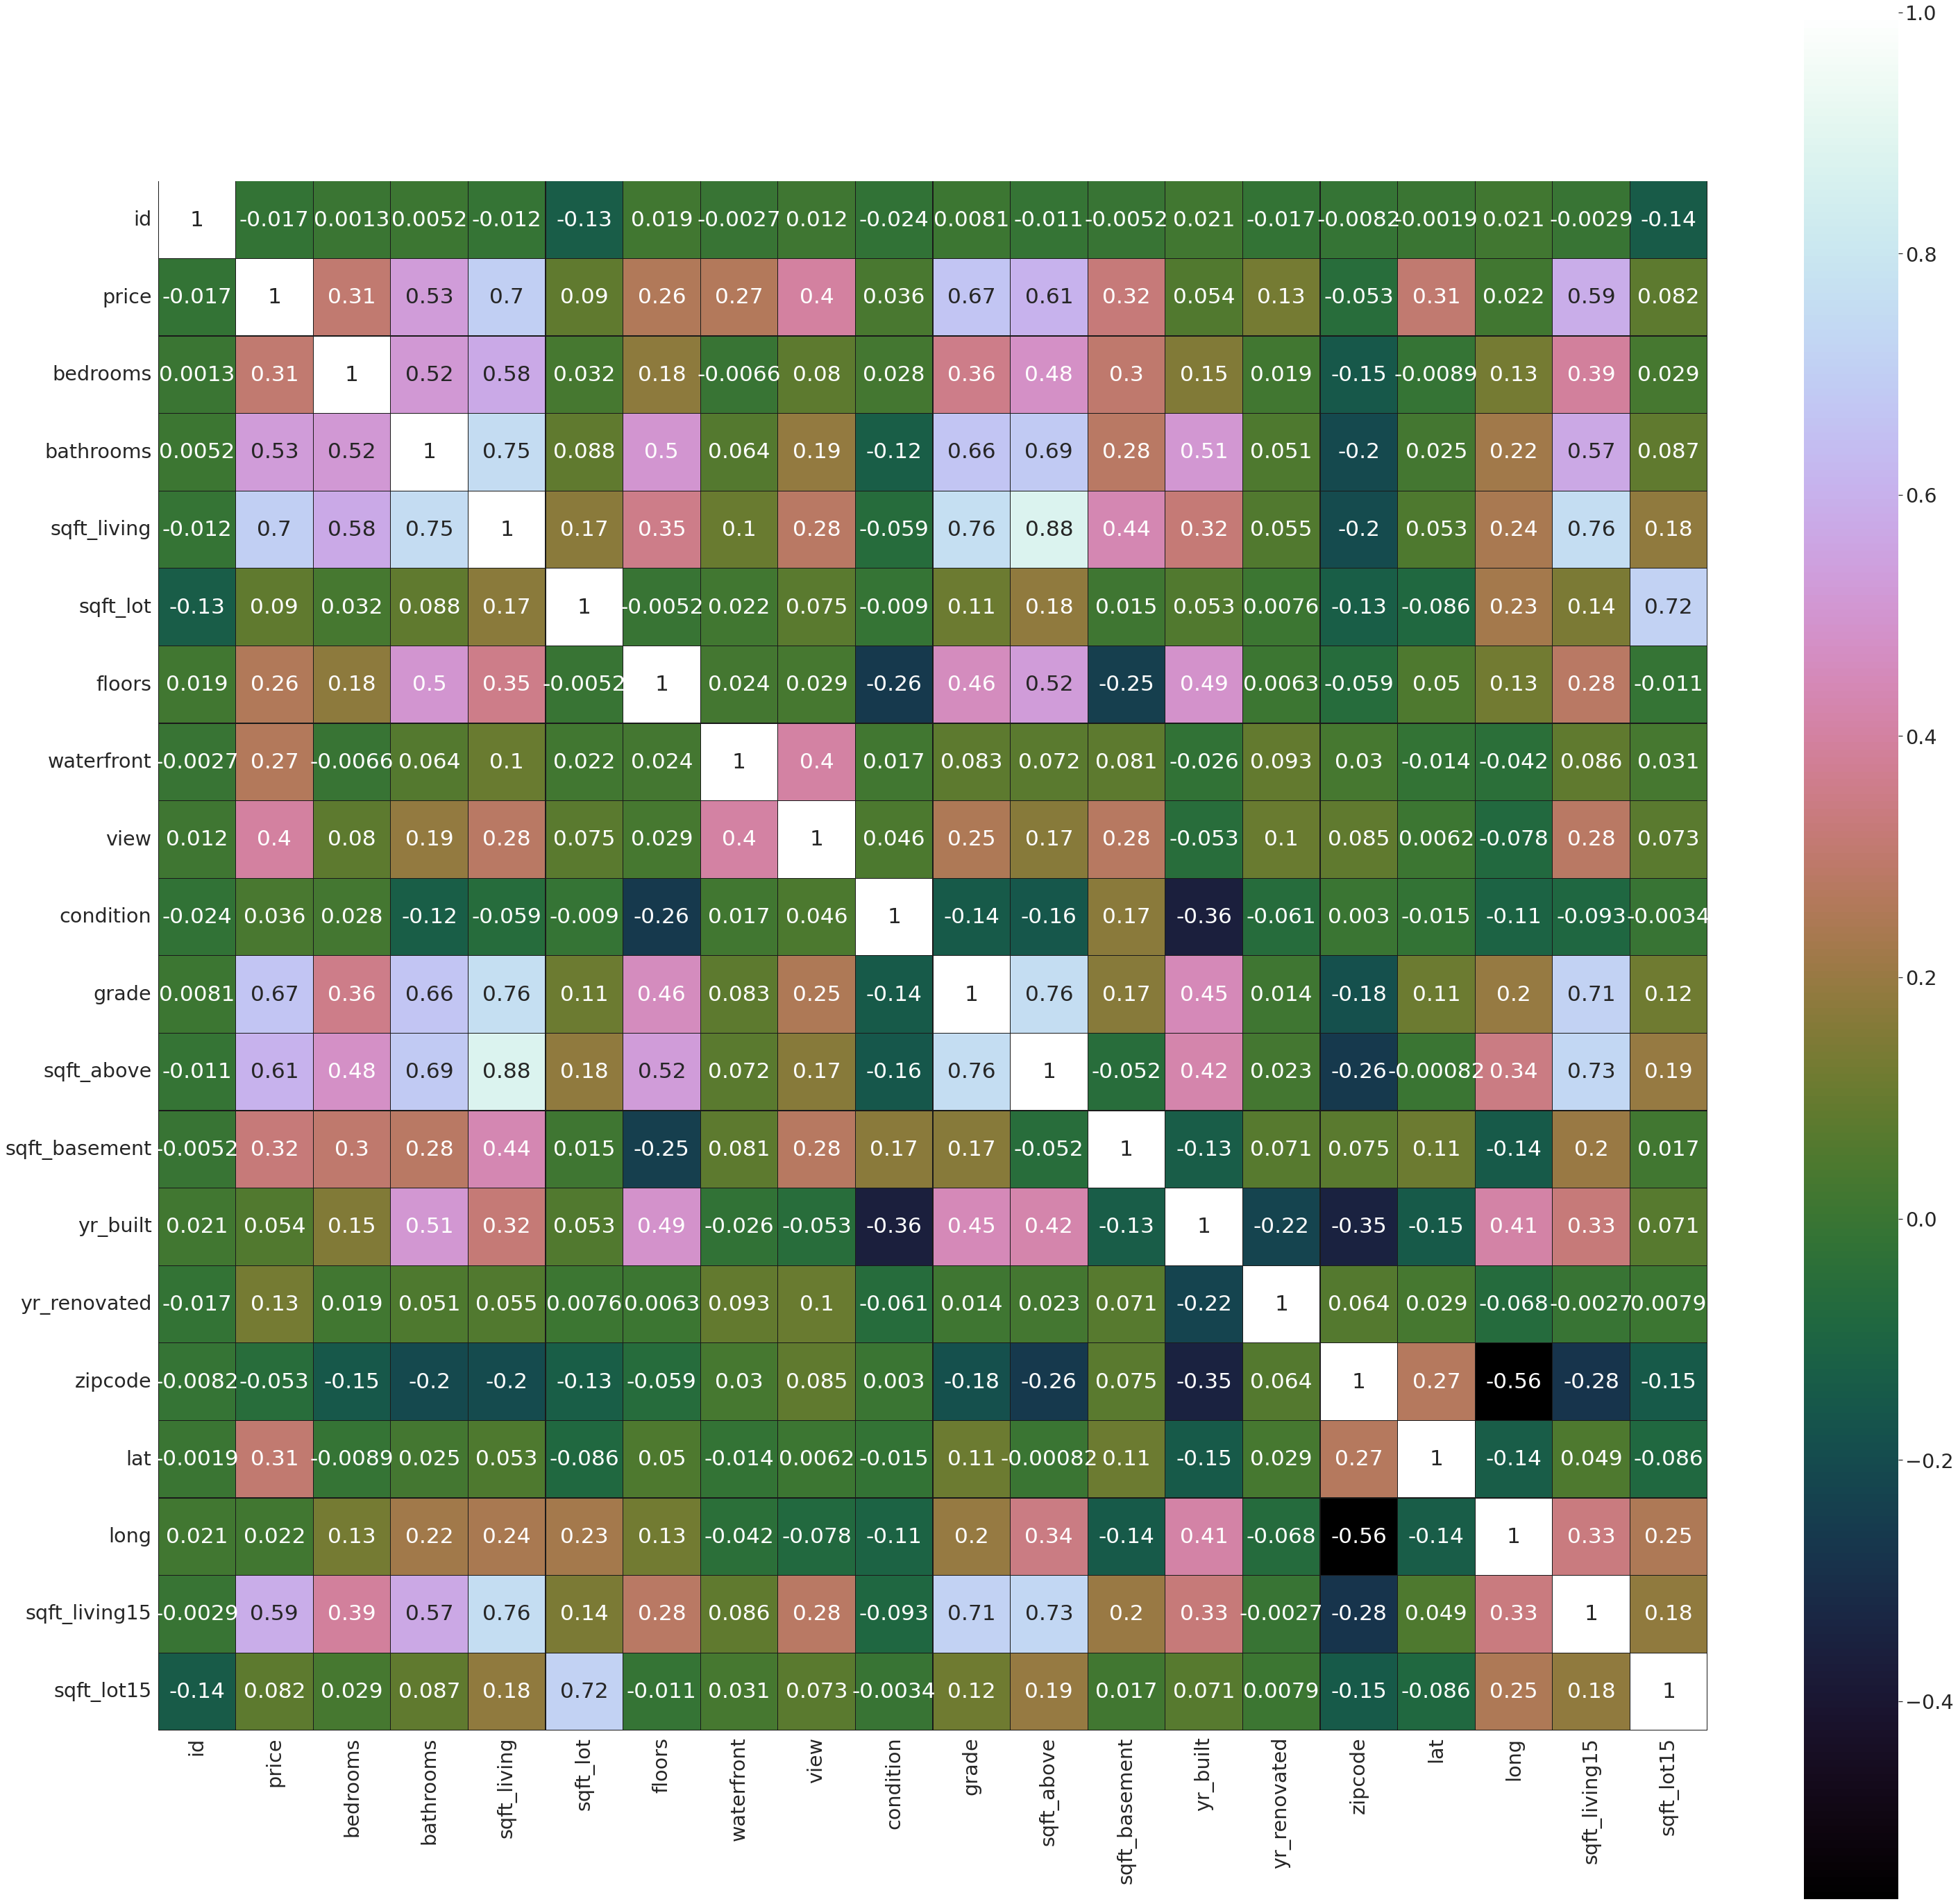

In [ ]:
#Sayısal verilerin birbirleriyle ilişkilerini ve bu ilişkilerin ne kadar önemli olduğunu gösteren bir ısı haritası oluşturuldu

plt.figure(figsize=(50,50))#Varsayılan ısı haritası boyutu okumaya pek de elverişli olmadığından büyütüldü, sayıların punktosu da aynı şekilde arttırıldı
sns.set(font_scale=2.6)
sns.heatmap(dataset[numerical_columns].astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, cmap="cubehelix", linecolor='k', annot=True)

**Isı Haritasından Çıkarılabilecek Sonuçlar**

Parametrelerin evin fiyatıyla ilişkileri:
1.   Bir evin fiyatının belirlenmesinde en etkili faktör 0.7'lik correlation'la '*sqft_living*' yani evin kullanılabilecek iç alanıdır.

    1.2.  Evin fiyatının belirlenmesindeki diğer iki en önemli faktörse '*grade*' (evin yapısal ve tasarımsal olarak durumu) ve '*sqft_above*' (evin bodrum katı hariç iç alanı)

2.   Evin fiyatıyla '*id*' ve '*zipcode*' arasında negative correlation bulunmasının mantıklı olmaması ve bu değerlerin 0'a çok yakın  olması sebebiyle bu iki özelliğin Linear Regression modelinde kullanılmamasına karar verildi.

Bazı parametrelerin diğerleriyle ilişkileri:
1.   '*View*': Evin manzarasının ne kadar iyi olduğunu belirtir. Evin su kenarına yakınlığıyla kuvvetli bir ilişkisi vardır. Evin fiyatı üzerindeki etkisi yadsınamaz seviyededir.


2.   '*Grade*': Evin güncel durumunun ne kadar iyi olduğunu gösteren bu parametre, '*yr_built*' parametresiyle büyük ölçüde doğru orantılıdır. Bir diğer deyişle ev ne kadar eskiyse '*grade*' değerinin o kadar azalması beklenir.


3.   Her ne kadar 'sqft_living', 'sqft_basement', 'sqft_above' ve 'sqft_living15' aynı olmasalar da bu parametreler tamamen ayrı tutulmamalıdır.
  *   'sqft_living', 'sqft_basement' ve 'sqft_above' parametrelerinin yaklaşık olarak toplamına eşittir.
  * Aynı zamanda Çevredeki evlerin ortalama iç alanını gösteren 'sqft_living15' parametresinin 'sqft_living' ile arasında 0.76'lık bir positive correlation söz konusudur. Bir diğer deyişle bir evin büyük ihtimalle civar evlerle benzer iç alana sahip olması beklenir.





In [ ]:
#Üstte bahsedildiği gibi 'id' ve 'zipcode' numerical_columns listesinden çıkarıldı
numerical_columns.remove("id")
numerical_columns.remove("zipcode")

#Aynı zamanda 'price' bağımlı değişken olduğundan çıkarıldı
numerical_columns.remove("price")


###Verileri ayırma ve normalleştirme

Derin Öğrenme modelini oluşturmadan önce kullanacağımız veriyi modelin üzerinde en iyi çalışabileceği duruma getirmek mantıklı olacaktır.

Bunun için:


1.   Datasetteki verileri X (bağımsız değişkenler) ve y (bağımlı değişken) olmak üzere ayırmak
2.   Train (modelin öğrenme sürecinde kullanacağı) ve Test (modelin değerlendirme sürecinde kullanacağı) setleri oluşturmak
3.   Bu setlerdeki verilerin sayısal olanlarını normalleştirmek, sayısal olmayanları "one-hot encoding" işleminden geçirmek




In [ ]:
#3. maddede bahsedilen işlemler için kullanılacak column_transformer oluşturuldu.
ct = make_column_transformer(
    (MinMaxScaler(), numerical_columns), #En basit tabirle column_transformer sayısal verileri 0 ile 1 arasındaki değerlere dönüştürecek. Farklı aralıklardaki verileri ortak bir aralığa getirmek model için verileri okumayı kolaylaştıracak.
    (OneHotEncoder(handle_unknown="ignore"), categorical_columns) #Sayısal olmayan verileri sayısal bir formata dönüştürmek için transistörlere benzer bir sistem kullanılacak. (Değer eşitse 1, değilse 0)
)

In [ ]:
#X, y, train-test setleri oluşturuldu
#Bu problemde bağımlı değişkenimiz(y) 'price' yani evin fiyatı. Bağımsız değişkenlerse kalan tüm özellikler.
X=dataset.drop("price", axis=1)
y=dataset["price"]

#Oluşturduğumuz setler %80 train - %20 test olmak üzere ayrıldı
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Column_transformer verilerimiz üzerinde kullanılmak için uygun hale getirildi
ct.fit(X_train)

#X_train ve X_test setlerindeki veriler normalleştirildi
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

###Linear Regression Modelini Oluşturma ve Çalıştırma

In [ ]:
#Sonraki aşamalar için global random seed ayarlandı
tf.random.set_seed(42)
#Kullanacağımız model oluşturuldu.
#Activation fonksiyonu "rectified linear unit" olan 5 katmandan oluşan modelde katmanlardaki nöron sayısı gitikçe azalmaktadır (100'den 1'e)
#Modeldeki tüm değerler yapılan deneyler sonucunda aşama aşama ilerletilerek bulunmuştur. Bir diğer deyişle model olabilecek en iyi model olmayabilir.
model = tf.keras.Sequential([
  tf.keras.layers.Dense(100, activation="relu"),
  tf.keras.layers.Dense(50, activation="relu"),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1, activation="relu")
])

#Modelin kurulumu yapıldı
#Modelin ekranda göstereceği hata değerinin "mean absolute error" olmasına karar verildi.
#Modelin doğruluk payını ve eğitim kalitesini önemli ölçüde etkileyen bir kısım olan optimizerın Adam optimizer'ı olmasına karar verildi.
      #Optimizer, modelin veriler arasındaki ilişkileri (patterns) fark etmesine yardımcı olur.
#Optimizer'ın öğrenme hızının varsayılan değer olan 0.001'den 0.1'e çıkarılmasına karar verildi. Öğrenme hızının arttırılmasının modelin başarı oranını arttırdığı gözlemlendi.
model.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.Adam(lr=0.1),
              metrics=["mae"])

#Model, train setleriyle eğitildi. Train setleri baştan sona 200 kez modele gösterildi (epoch sayısı modelin kaç kez verileri tekrardan göreceğini belirler.)
model.fit(X_train_normal.toarray(), y_train, epochs=200)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/200
541/541 [==============================] - 2s 2ms/step - loss: 154649.7031 - mae: 154649.7031
Epoch 2/200
541/541 [==============================] - 1s 2ms/step - loss: 126066.4375 - mae: 126066.4375
Epoch 3/200
541/541 [==============================] - 1s 2ms/step - loss: 121605.3672 - mae: 121605.3672
Epoch 4/200
541/541 [==============================] - 1s 2ms/step - loss: 117137.7578 - mae: 117137.7578
Epoch 5/200
541/541 [==============================] - 1s 2ms/step - loss: 115307.9297 - mae: 115307.9297
Epoch 6/200
541/541 [==============================] - 1s 2ms/step - loss: 112511.7891 - mae: 112511.7891
Epoch 7/200
541/541 [==============================] - 1s 2ms/step - loss: 110934.6094 - mae: 110934.6094
Epoch 8/200
541/541 [==============================] - 1s 2ms/step - loss: 108794.0703 - mae: 108794.0703
Epoch 9/200
541/541 [==============================] - 1s 2ms/step - loss: 107318.3125 - mae: 107318.3125
Epoch 10/200
541/541 [========================

###Modeli Test Etme

Kullanılacak test metodu:

1.  Modele daha önce görmediği bağımsız değişkenler üzerinden bağımlı değişken tahminleri yaptır.
2.   Bu tahminleri gerçek sonuçlarla karşılaştırarak r2 score hesapla.



In [ ]:
#Modelin değerlendirilmesi için r2_score kullanıldı
from sklearn.metrics import r2_score
#Modele normalleştirilmiş bağımsız değişkenlerden oluşan test seti gösterilerek ev fiyatı tahmini yaptırıldı.
y_predicts = model.predict(X_test_normal)
#Hazır bir fonksiyon olan r2_score ile gerçek ev fiyatları modelin tahminleriyle karşılaştırıldı.
r2_score(y_test, y_predicts)

#Elde edilen r2_score: 0.7780021418303413

0.7780021418303413

###Kaynakça

Chollet, François. "Basic regression: Predict fuel efficiency". Tensorflow, tensorflow.org, Last updated 2022-06-16, https://www.tensorflow.org/tutorials/keras/regression.

"Learn TensorFlow and Deep Learning fundamentals with Python (code-first introduction) Part 1/2". *Youtube*, uploaded by Daniel Bourke, 16.03.2021, https://www.youtube.com/watch?v=tpCFfeUEGs8&t=1s.


"TensorFlow 2.0 Complete Course - Python Neural Networks for Beginners Tutorial". *Youtube*, uploaded by
freeCodeCamp.org, 03.03.2020, https://www.youtube.com/watch?v=tPYj3fFJGjk&t=1s.
